### **1. Causal Graph and Setup**

Figure and setting from: Binkytė, R., Grozdanovski, L. and Zhioua, S., 2022. On the Need and Applicability of Causality for Fairness: A Unified Model for AI Auditing and Legal Analysis. arXiv preprint arXiv:2207.04053., https://arxiv.org/abs/2207.04053

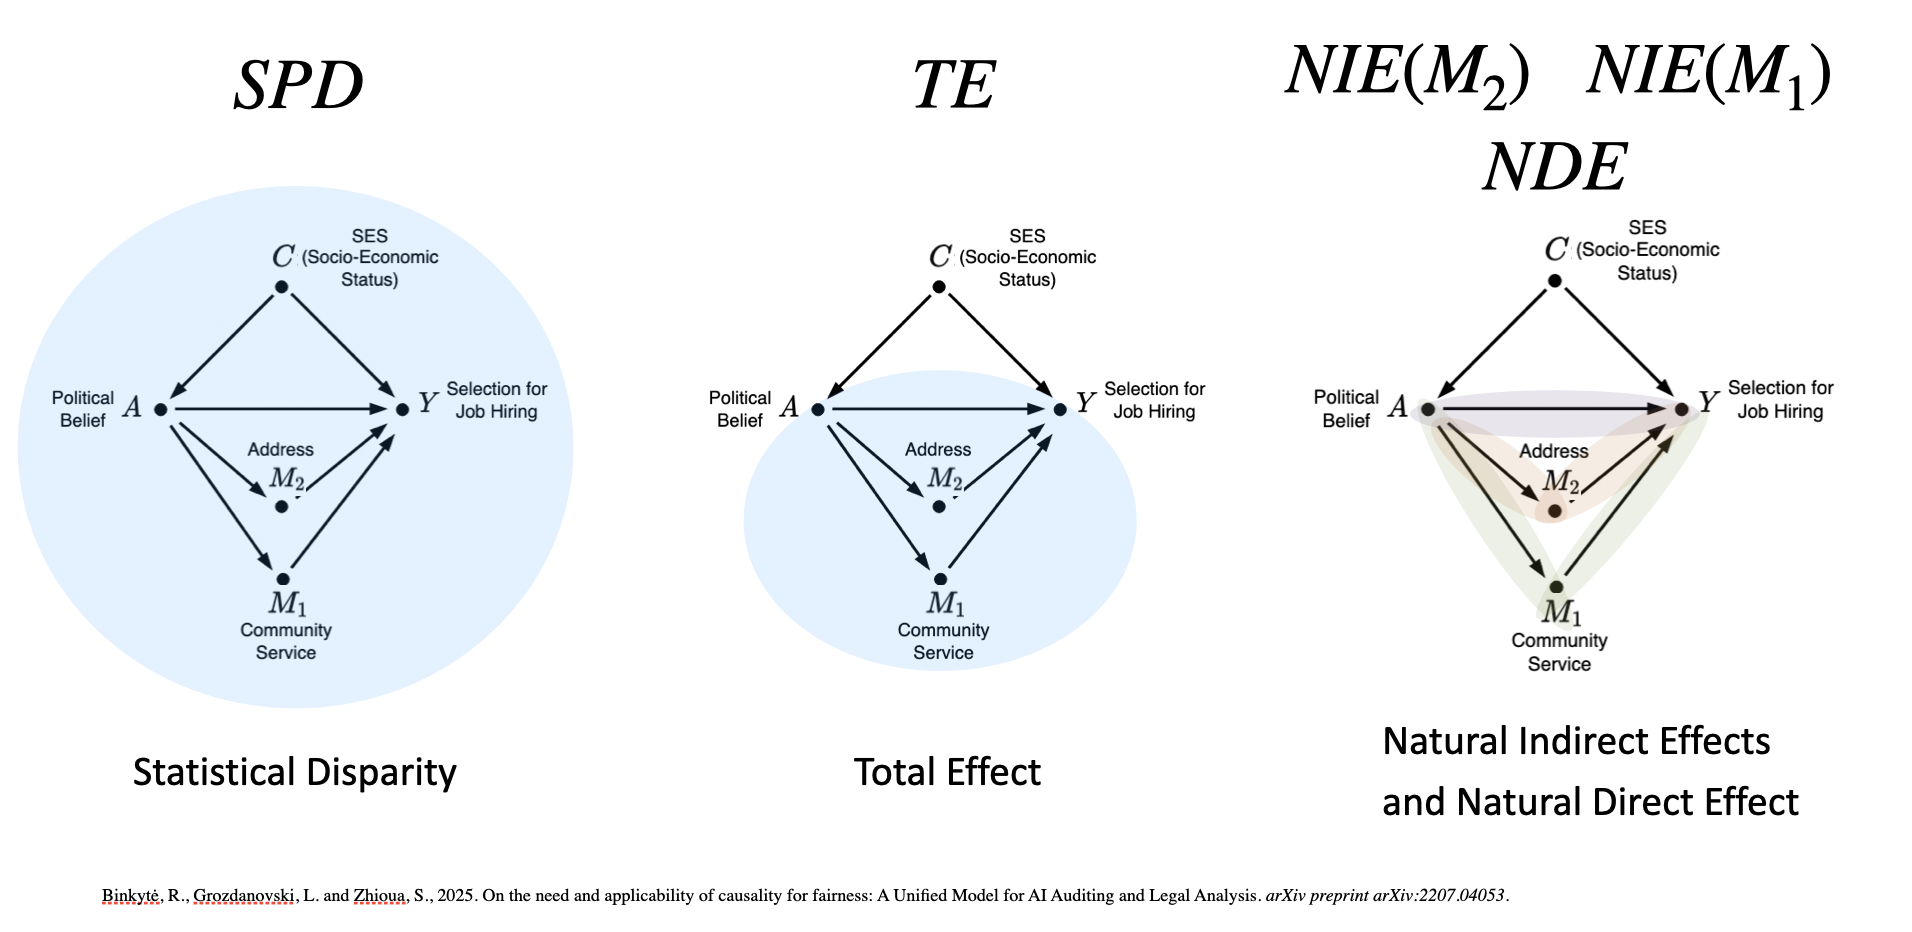

<p>We have a binary sensitive attribute <strong>A</strong> = “<em>Political Belief</em>” (0 = Conservative, 1 = Liberal). We want to explain outcome <strong>Y</strong> = “<em>Hiring Decision</em>” ∈ {0,1}.</p>

<ul>
  <li><strong>C</strong> = Confounder “<em>Socio-Economic Status (SES)</em>” (let’s treat it as 0 = High SES, 1 = Low SES).</li>
  <li><strong>M<sub>1</sub></strong> = Mediator 1 “<em>Amount of Community Service</em>”</li>
  <li><strong>M<sub>2</sub></strong> = Mediator 2 “<em>Address</em>” (0 = Rural, 1 = Urban)</li>
</ul>

<p>The direct edges in the graph are:</p>
<p><strong>A → Y</strong>, <strong>A → M<sub>1</sub> → Y</strong>, <strong>A → M<sub>2</sub> → Y</strong>, <strong>A ← C → Y</strong></p>

<p><strong>Intuitively:</strong></p>
<ul>
  <li><strong>A ← C</strong>: Low SES is more common among liberals, and that might also affect hiring decisions.</li>
  <li><strong>A → M<sub>1</sub></strong>: Liberals (on average) do slightly more community service (perhaps more volunteering).</li>
  <li><strong>A → M<sub>2</sub></strong>: Liberals (on average) are more likely to live in urban locations.</li>
  <li>Both <strong>M<sub>1</sub></strong> and <strong>M<sub>2</sub></strong> in turn affect <strong>Y</strong>.</li>
  <li>Also, there can be a direct path <strong>A → Y</strong> capturing any direct bias in hiring decisions once we control for the other factors.</li>
</ul>


### **2. Definitions and Key Formulas**
2.1. Statistical Parity (a.k.a. Statistical Disparity)

A fairness metric that simply looks at differences in outcome rates between groups:
<p><strong>Statistical Parity</strong> = Pr[Y = 1 | A = 1] − Pr[Y = 1 | A = 0]</p>

<p>Here, a negative result means that liberals (A = 1) have a lower probability of hiring than conservatives (A = 0), suggesting possible discrimination.</p>


<h3>2.2. Total, Direct, and Indirect Effects</h3>

<p>Let’s define potential outcomes for each individual <em>i</em>. The variable <strong>Y<sub>i</sub>(a)</strong> denotes the value of <strong>Y</strong> if we were to “intervene” (or set) A = a. For multiple mediators <strong>M<sub>1</sub>, M<sub>2</sub></strong>, define <strong>Y<sub>i</sub>(a, m<sub>1</sub>, m<sub>2</sub>)</strong> similarly. Then:</p>

<p><strong>Total Effect (TE)</strong> of <strong>A</strong> on <strong>Y</strong>:<br>
<code>TE = E[Y(a = 1)] − E[Y(a = 0)]</code></p>

<p><strong>Natural Direct Effect (NDE)</strong>: the effect of changing <strong>A</strong> from 0 to 1 while “holding mediators fixed” at whatever they would have been under A = 0. Symbolically:<br>
<code>NDE = E[Y(a = 1, M<sub>1</sub>(a = 0), M<sub>2</sub>(a = 0))] − E[Y(a = 0, M<sub>1</sub>(a = 0), M<sub>2</sub>(a = 0))]</code></p>

<p><strong>Natural Indirect Effect (NIE)</strong> through <strong>M<sub>1</sub></strong>: holding the other mediator <strong>M<sub>2</sub></strong> at its “natural” value under A = 0, we see how changing <strong>A</strong> from 0 to 1 changes <strong>M<sub>1</sub></strong>, and thus <strong>Y</strong>. For example:<br>
<code>NIE<sub>M1</sub> = E[Y(a = 0, M<sub>1</sub>(a = 1), M<sub>2</sub>(a = 0))] − E[Y(a = 0, M<sub>1</sub>(a = 0), M<sub>2</sub>(a = 0))]</code></p>

<p>Similarly, you can define <code>NIE<sub>M2</sub></code>.</p>

<p>Depending on your notation, you can define these “one mediator at a time” or define a decomposition for multi-mediator settings. In practice, if you want to isolate each mediator’s share of the effect, you typically vary them one at a time.</p>


### **3. Synthetic Data Generation**

We’ll simulate a scenario in which:

- $ A = 1 $ (Liberal) is correlated with $ C = 1 $ (Low SES)  
  _(i.e., liberals are more likely low SES)_.
- Low SES reduces the chance of hiring (part of the confounding).
- Liberals have a direct negative effect on $ Y $  
  _(some form of direct “political bias” in hiring)_.
- Liberals have higher $ M_1 $ (community service hours), which in turn improves their hiring chances.
- Liberals also more often live in cities ($ M_2 = 1 $), but suppose that living in an urban area slightly improves hiring odds (maybe more accessible job networks) or slightly hurts them—choose whichever helps illustrate a point.  
  _We’ll pick a mild positive effect._

We want the end result that:

- **Overall**:  
  $ \Pr[Y = 1 \mid A = 1] < \Pr[Y = 1 \mid A = 0] \quad \Rightarrow \quad \text{"liberals appear discriminated" by raw numbers}$
- But once we account for $ C $, we see it’s largely confounding.
- Also, the “community service” path helps liberals a bit  
  _(so there is a partial “positive” indirect effect offsetting the direct negative effect)_.

Below is an example setup. Adjust the numeric parameters as you like to emphasize the effect.


In [ ]:
import numpy as np
import pandas as pd

np.random.seed(123)  # for reproducibility

N = 2000

# 1) Generate A: Probability of being Liberal = pA
pA = 0.4
A = np.random.binomial(1, pA, size=N)

# 2) Generate C (SES): Probability of Low SES is higher for Liberals
#    P(C=1 | A=1) = 0.6, P(C=1 | A=0) = 0.3
C = np.array([
    np.random.binomial(1, 0.6 if a==1 else 0.3)
    for a in A
])

# 3) Generate M1 (community service hours).
#    Let M1 ~ Normal(mu, sigma), with higher mean for Liberals
#    Also let Low SES reduce M1 a bit.
M1 = []
for i in range(N):
    base = 3.0  # baseline hours
    if A[i] == 1:
        base += 2.0  # liberals do more volunteering
    if C[i] == 1:
        base -= 1.0  # low SES might reduce volunteering opportunities
    val = np.random.normal(base, 1.0)  # some noise
    M1.append(val)
M1 = np.array(M1)

# 4) Generate M2 (address = 1 if urban, 0 if rural).
#    Let's say Liberals are more likely urban, and Low SES is also more likely urban,
#    but we can tweak it.
M2 = []
for i in range(N):
    if A[i] == 1:
        p_urban = 0.7
    else:
        p_urban = 0.3
    # Maybe also tweak with C if we want:
    if C[i] == 1:
        p_urban += 0.1  # low SES also more likely in some urban areas, say
    p_urban = min(max(p_urban, 0), 1)  # clamp to [0,1]
    M2.append(np.random.binomial(1, p_urban))
M2 = np.array(M2)

# 5) Generate Y (Hiring) using a logistic model:
#    Y = sigmoid( beta0 + betaA*A + betaC*C + beta1*M1 + beta2*M2 + noise )
#    We'll pick negative betaA for direct bias against liberals,
#    negative betaC for low SES,
#    positive beta1 for M1,
#    small positive beta2 for M2.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

beta0 = -1.0   # baseline
betaA = -0.8   # direct bias against liberals
betaC = -1.5   # negative effect of low SES
beta1 =  0.3   # more community service => better chance
beta2 =  0.2   # living urban => slight advantage

linpred = beta0 + betaA*A + betaC*C + beta1*M1 + beta2*M2
prob = sigmoid(linpred)
Y = np.random.binomial(1, prob)

# Put into a DataFrame
df = pd.DataFrame({
    'A': A,
    'C': C,
    'M1': M1,
    'M2': M2,
    'Y': Y
})

df.head(10)


,A,C,M1,M2,Y
0,1,1,2.879997,1,0
1,0,0,3.363630,0,0
2,0,0,2.623074,0,0
3,0,1,2.319489,0,1
4,1,0,5.457127,0,0
5,0,1,0.336426,0,0
6,1,0,4.771921,0,1
7,1,1,4.089649,1,0
8,0,0,1.747675,0,0
9,0,0,2.264652,0,1


###  *Quick Check: Statistical Parity*

We can compute:

$$
\Pr[Y = 1 \mid A = 1], \quad \Pr[Y = 1 \mid A = 0], \quad \text{and then} \quad \text{SP} = \text{difference}.
$$

That is:

$$
\text{SP} = \Pr[Y = 1 \mid A = 1] - \Pr[Y = 1 \mid A = 0]
$$


Expect to see a negative number if liberals are hired less often, indicating “raw disparity” against liberals.

In [ ]:
mean_y_liberal = df.loc[df['A']==1, 'Y'].mean()
mean_y_conserv = df.loc[df['A']==0, 'Y'].mean()
stat_parity = mean_y_liberal - mean_y_conserv

print(f"Pr[Y=1 | A=1] = {mean_y_liberal:.3f}")
print(f"Pr[Y=1 | A=0] = {mean_y_conserv:.3f}")
print(f'Statistical Parity (liberal - conservative) = {stat_parity:.3f}')


Pr[Y=1 | A=1] = 0.289
Pr[Y=1 | A=0] = 0.373
Statistical Parity (liberal - conservative) = -0.084


### **4 Mediation Analysis: Setup and Key Assumptions**

To identify natural direct/indirect effects, we typically assume:

- No unmeasured confounding of  
  $$ A \rightarrow Y, \quad A \rightarrow M_j, \quad M_j \rightarrow Y $$
- Stable Unit Treatment Value Assumption (SUTVA) and positivity assumptions.
- Sequential ignorability for mediation — roughly, that after controlling for  
  $ A \text{ and } C $  
  there is no additional unmeasured confounder of  
  $ M_j \rightarrow Y $

In real data, these can be strong assumptions. Here we are working with a synthetic scenario where we know the data-generating process, so they hold by construction.


### **5.Indirect and Direct Effects via (Simple) Imputation**

#### 5.1. Potential Outcomes as Missing Data

A helpful conceptual approach is to note that for each individual *i*:

- We observe $ Y_i $ under the actually assigned $ A_i $.
- We do **not** observe $ Y_i $ for the counterfactual scenario $ 1 - A_i $.
- If we want the natural indirect effect through $ M_1 $, we also need to imagine  
  $ M_1(a = 1) \quad \text{and} \quad M_1(a = 0) $.

Below is a small illustrative table for 3 hypothetical individuals.  
Notice the “missing cells” for the “counterfactual” columns:


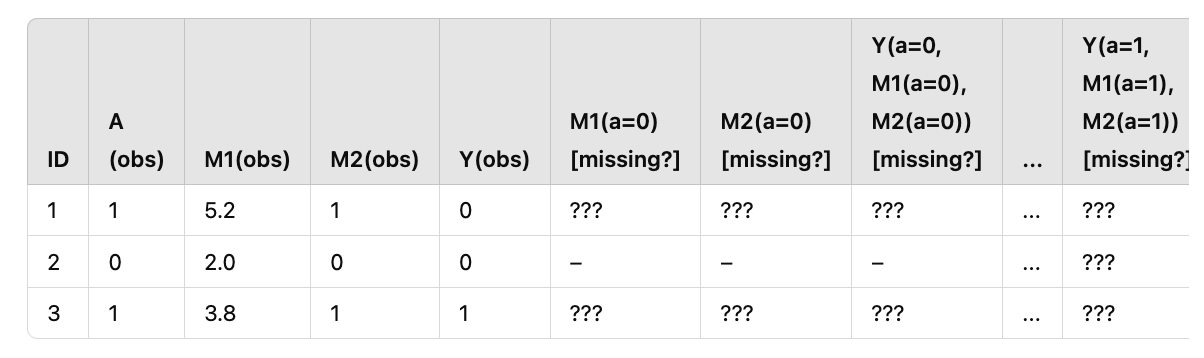

Here “–” indicates not missing if it matches their actual A value, while “???” indicates the unobserved potential outcomes.

### 5.2. Parametric Imputation Strategy

We can impute these missing potential outcomes by:

- Fitting models for $ M_1 $ and $ M_2 $ as functions of $ A, C $.
- Fitting a model for $ Y $ as a function of $ A, M_1, M_2, C $.
- For each individual:
  - Predict $ \hat{M}_1(a) $ by setting $ A = a $ but leaving their $ C $ at the observed value.
  - Predict $ \hat{M}_2(a) $ similarly.
  - Then plug in $ \hat{M}_1(a) $ and $ \hat{M}_2(a) $ (and $ A = a, C $) into the fitted $ Y $ model to get  
    $
    \hat{Y}(a, \hat{M}_1(a), \hat{M}_2(a))
    $

We can also do more complicated “bootstrapping” or “Monte Carlo draws” from the distribution of errors, but let’s keep it straightforward.

Below is an example using `statsmodels` to fit these regressions, do the imputation, and compute the effects.


In [ ]:
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial

# 7.1 Fit mediator models M1, M2
#     M1 is continuous => OLS, M2 is binary => logistic
#     We'll include A and C as predictors, since M1, M2 depends on A, C.
model_m1 = smf.ols('M1 ~ A + C', data=df).fit()
model_m2 = smf.glm('M2 ~ A + C', data=df, family = Binomial()).fit()

# 7.2 Fit outcome model Y with A, M1, M2, C
model_y = smf.glm('Y ~ A + M1 + M2 + C', data=df, family = Binomial()).fit()

print("Mediator M1 model:\n", model_m1.params, "\n")
print("Mediator M2 model:\n", model_m2.params, "\n")
print("Outcome Y model:\n", model_y.params)

Mediator M1 model:
 Intercept    3.067638
A            1.969566
C           -1.004274
dtype: float64 

Mediator M2 model:
 Intercept   -0.925220
A            1.676439
C            0.567514
dtype: float64 

Outcome Y model:
 Intercept   -1.269814
A           -0.688388
M1           0.349655
M2           0.364753
C           -1.705126
dtype: float64


**Interpretation** of the fits (roughly) should align with how we generated the data, e.g., negative coefficient for A in the Y model, etc.

### 5.3. Impute Potential Outcomes

Now we do a “two-step” approach for each subject:

For each subject *i*, produce:

- $ \hat{M}_1(a) = \text{predict}(M_1 \mid A = a, C_i) $
- $ \hat{M}_2(a) = \Pr(M_2 = 1 \mid A = a, C_i) $  
  _(the predicted probability for $ M_2 $)_

Insert these values into the outcome model for  
$ \hat{Y}(a, m_1, m_2) $.

For a logistic model, we do:

$
\text{logit}(\hat{Y}) = \hat{\beta}_0 + \hat{\beta}_A \cdot a + \hat{\beta}_{M_1} \cdot m_1 + \hat{\beta}_{M_2} \cdot m_2 + \hat{\beta}_C \cdot C_i
$

We can do that in code:


In [ ]:
# We'll create columns in df for each potential outcome of interest:
# Y(a=0), Y(a=1),
# Y(a=0, M1(a=1), M2(a=0)), etc., as needed for direct & indirect effects.

df = df.copy()  # just to avoid overwriting

# 1) Predict M1(a) for a=0,1
df['M1_hat_a0'] = model_m1.predict(df.assign(A=0))
df['M1_hat_a1'] = model_m1.predict(df.assign(A=1))

# 2) Predict Probability M2(a=0), M2(a=1)
df['M2_hat_a0'] = model_m2.predict(df.assign(A=0))
df['M2_hat_a1'] = model_m2.predict(df.assign(A=1))

# We'll create helper function to get predicted prob of Y given (A, M1, M2, C)
def predict_y(a, m1, m2, c):
    # Get linear predictor from the model_y coefficients:
    lp = (model_y.params['Intercept']
          + model_y.params.get('A',0)*a
          + model_y.params.get('M1',0)*m1
          + model_y.params.get('M2',0)*m2
          + model_y.params.get('C',0)*c)
    return 1/(1+np.exp(-lp))

# 3) Impute Y(a) = Y(a, M1(a), M2(a)):
df['Y_hat_a0'] = predict_y(
    0,
    df['M1_hat_a0'],
    df['M2_hat_a0'],
    df['C']
)
df['Y_hat_a1'] = predict_y(
    1,
    df['M1_hat_a1'],
    df['M2_hat_a1'],
    df['C']
)

# 4) For direct effect, we want Y(a=1, M1(a=0), M2(a=0)) etc.
#    We'll define a few relevant combos:

# Natural Direct Effect for moving A:0->1 while "holding M1, M2 at their a=0 level"
df['Y_hat_direct'] = predict_y(
    1,
    df['M1_hat_a0'],
    df['M2_hat_a0'],
    df['C']
)

# Indirect effect through M1 only:
# Keep A=0, M2 = M2_hat_a0, but swap M1 to M1_hat_a1
df['Y_hat_indir_m1'] = predict_y(
    0,
    df['M1_hat_a1'],
    df['M2_hat_a0'],
    df['C']
)

# Indirect effect through M2 only:
# Keep A=0, M1 = M1_hat_a0, but swap M2 to M2_hat_a1
df['Y_hat_indir_m2'] = predict_y(
    0,
    df['M1_hat_a0'],
    df['M2_hat_a1'],
    df['C']
)

# Predict counterfactual outcomes using the actual Y model
# This is the same model used above: model_y

# Predict Y under A=0 with predicted mediators M1(A=0), M2(A=0)
df['Y_actual_a0'] = predict_y(
    0,
    df['M1_hat_a0'],
    df['M2_hat_a0'],
    df['C']
)

# Predict Y under A=1 with predicted mediators M1(A=1), M2(A=1)
df['Y_actual_a1'] = predict_y(
    1,
    df['M1_hat_a1'],
    df['M2_hat_a1'],
    df['C']
)

df.head(10)


,A,C,M1,M2,Y,M1_hat_a0,M1_hat_a1,M2_hat_a0,M2_hat_a1,Y_hat_a0,Y_hat_a1,Y_hat_direct,Y_hat_indir_m1,Y_hat_indir_m2,Y_actual_a0,Y_actual_a1
0,1,1,2.879997,1,0,2.063364,4.032930,0.411515,0.788971,0.108769,0.122882,0.057771,0.195493,0.122852,0.108769,0.122882
1,0,0,3.363630,0,0,3.067638,5.037204,0.283896,0.679444,0.476606,0.512725,0.313882,0.644517,0.512655,0.476606,0.512725
2,0,0,2.623074,0,0,3.067638,5.037204,0.283896,0.679444,0.476606,0.512725,0.313882,0.644517,0.512655,0.476606,0.512725
3,0,1,2.319489,0,1,2.063364,4.032930,0.411515,0.788971,0.108769,0.122882,0.057771,0.195493,0.122852,0.108769,0.122882
4,1,0,5.457127,0,0,3.067638,5.037204,0.283896,0.679444,0.476606,0.512725,0.313882,0.644517,0.512655,0.476606,0.512725
5,0,1,0.336426,0,0,2.063364,4.032930,0.411515,0.788971,0.108769,0.122882,0.057771,0.195493,0.122852,0.108769,0.122882
6,1,0,4.771921,0,1,3.067638,5.037204,0.283896,0.679444,0.476606,0.512725,0.313882,0.644517,0.512655,0.476606,0.512725
7,1,1,4.089649,1,0,2.063364,4.032930,0.411515,0.788971,0.108769,0.122882,0.057771,0.195493,0.122852,0.108769,0.122882
8,0,0,1.747675,0,0,3.067638,5.037204,0.283896,0.679444,0.476606,0.512725,0.313882,0.644517,0.512655,0.476606,0.512725
9,0,0,2.264652,0,1,3.067638,5.037204,0.283896,0.679444,0.476606,0.512725,0.313882,0.644517,0.512655,0.476606,0.512725


### 5.4. Estimate Effects

Now we can take averages across the dataset to get:

- **Total Effect**:  
  $
  \mathbb{E}[Y(a = 1)] - \mathbb{E}[Y(a = 0)] = \text{mean of } \hat{Y}_{a=1} \text{ minus mean of } \hat{Y}_{a=0}
  $

- **Natural Direct Effect**:  
  $
  \mathbb{E}[Y(a = 1, M(a = 0))] - \mathbb{E}[Y(a = 0, M(a = 0))] = \text{mean of } \hat{Y}_{\text{direct}} \text{ minus mean of } \hat{Y}_{a=0}
  $

- **Natural Indirect Effect** (e.g., through $ M_1 $), etc.


In [ ]:
# Compute Total Effect on Yhat
TEYhat = df['Y_hat_a1'].mean() - df['Y_hat_a0'].mean()
# Compute Total Effect on Y
TEY = df['Y_actual_a1'].mean() - df['Y_actual_a0'].mean()
NDE = df['Y_hat_direct'].mean() - df['Y_hat_a0'].mean()

# Indirect effect via M1:
NIE_m1 = df['Y_hat_indir_m1'].mean() - df['Y_hat_a0'].mean()

# Indirect effect via M2:
NIE_m2 = df['Y_hat_indir_m2'].mean() - df['Y_hat_a0'].mean()

print(f"Total Effect Y hat: {TEYhat:.4f}")
print(f"Total Effect Y: {TEY:.4f}")
print(f"Natural Direct Effect: {NDE:.4f}")
print(f"Natural Indirect Effect (M1 only): {NIE_m1:.4f}")
print(f"Natural Indirect Effect (M2 only): {NIE_m2:.4f}")


Total Effect Y hat: 0.0272
Total Effect Y: 0.0272
Natural Direct Effect: -0.1173
Natural Indirect Effect (M1 only): 0.1349
Natural Indirect Effect (M2 only): 0.0271


Typically, we’d check that: $\text{TE} \approx \text{NDE} + \text{(some combination of NIEs)}$

Because we have two mediators simultaneously, you can do more advanced decompositions (e.g., synergy terms), but the above is often enough to see that part of the effect is **direct** (from the “political label”) and part is **mediated** by community service or address.


In [ ]:
import pandas as pd
from IPython.display import display

###############################
# 1) Observed Group Hiring Rates & Statistical Parity
###############################

table_sp = pd.DataFrame({
    "Measure": [
        "P(Y=1 | Liberal)",
        "P(Y=1 | Conservative)",
        "Statistical Parity (L - C)"
    ],
    "Value": [
        f"{mean_y_liberal:.3f}",
        f"{mean_y_conserv:.3f}",
        f"{stat_parity:.3f}"
    ]
})

print("## 1) Observed Hiring Rates & Statistical Parity")
display(table_sp)

print("""
**Brief Interpretation**:
- P(Y=1 | Liberal) and P(Y=1 | Conservative) are the observed (raw) hiring rates.
- Statistical Parity = (Liberal rate - Conservative rate).
  A negative result indicates that liberals are hired at a lower rate in raw data.
""")

###############################
# 2) Mediator Model Parameters
###############################

# 2a) M1 (OLS)
param_m1 = model_m1.params
table_m1 = pd.DataFrame({
    "Parameter": param_m1.index,
    "Estimate": param_m1.values
})
print("## 2a) Mediator M1 Model (OLS) Parameters")
display(table_m1)

print("""
**Brief Interpretation**:
- Intercept: Baseline community-service hours when A=0, C=0.
- A: Increase in M1 if A=1 (liberal).
- C: Effect of being low SES.
""")

# 2b) M2 (Logistic)
param_m2 = model_m2.params
table_m2 = pd.DataFrame({
    "Parameter": param_m2.index,
    "Estimate": param_m2.values
})
print("## 2b) Mediator M2 Model (Logistic) Parameters")
display(table_m2)

print("""
**Brief Interpretation**:
- Intercept: Baseline log-odds of M2=1 (urban) for A=0, C=0.
- A: Effect of being liberal on log-odds of living urban.
- C: Effect of low SES on log-odds of living urban.
""")

###############################
# 3) Outcome Y Model Parameters
###############################

param_y = model_y.params
table_y = pd.DataFrame({
    "Parameter": param_y.index,
    "Estimate": param_y.values
})

print("## 3) Outcome Y Model (Logistic) Parameters")
display(table_y)

print("""
**Brief Interpretation**:
- Intercept: Baseline log-odds of Y=1 (hiring) when A=0, M1=0, M2=0, C=0.
- A: Effect of liberal label on log-odds of hiring, controlling for M1, M2, C.
- M1: Effect of community service hours on hiring.
- M2: Effect of living urban on hiring.
- C: Effect of low SES on hiring.
""")

###############################
# 4) Causal Effects (Total, Direct, Indirect)
###############################

table_effects = pd.DataFrame({
    "Quantity": [
        "Total Effect (A=1 vs A=0)",
        "Natural Direct Effect",
        "Indirect Effect via M1",
        "Indirect Effect via M2"
    ],
    "Value": [
        f"{TE:.4f}",
        f"{NDE:.4f}",
        f"{NIE_m1:.4f}",
        f"{NIE_m2:.4f}"
    ]
})

print("## 4) Causal Effects (Total, Direct, Indirect)")
display(table_effects)

print("""
**Brief Interpretation**:
- **Total Effect**: Change in hiring probability from A=0 to A=1,
  through *all* causal paths.
- **Natural Direct Effect (NDE)**: Effect of flipping A=0→1 while
  holding mediators fixed at their A=0 levels.
- **Indirect Effect via M1** / M2: Effect transmitted through the
  respective mediator alone.
""")


## 1) Observed Hiring Rates & Statistical Parity


,Measure,Value
0,P(Y=1 | Liberal),0.289
1,P(Y=1 | Conservative),0.373
2,Statistical Parity (L - C),-0.084



**Brief Interpretation**:
- P(Y=1 | Liberal) and P(Y=1 | Conservative) are the observed (raw) hiring rates.
- Statistical Parity = (Liberal rate - Conservative rate).
  A negative result indicates that liberals are hired at a lower rate in raw data.

## 2a) Mediator M1 Model (OLS) Parameters


,Parameter,Estimate
0,Intercept,3.067638
1,A,1.969566
2,C,-1.004274



**Brief Interpretation**:
- Intercept: Baseline community-service hours when A=0, C=0.
- A: Increase in M1 if A=1 (liberal).
- C: Effect of being low SES.

## 2b) Mediator M2 Model (Logistic) Parameters


,Parameter,Estimate
0,Intercept,-0.925220
1,A,1.676439
2,C,0.567514



**Brief Interpretation**:
- Intercept: Baseline log-odds of M2=1 (urban) for A=0, C=0.
- A: Effect of being liberal on log-odds of living urban.
- C: Effect of low SES on log-odds of living urban.

## 3) Outcome Y Model (Logistic) Parameters


,Parameter,Estimate
0,Intercept,-1.269814
1,A,-0.688388
2,M1,0.349655
3,M2,0.364753
4,C,-1.705126



**Brief Interpretation**:
- Intercept: Baseline log-odds of Y=1 (hiring) when A=0, M1=0, M2=0, C=0.
- A: Effect of liberal label on log-odds of hiring, controlling for M1, M2, C.
- M1: Effect of community service hours on hiring.
- M2: Effect of living urban on hiring.
- C: Effect of low SES on hiring.

## 4) Causal Effects (Total, Direct, Indirect)


,Quantity,Value
0,Total Effect (A=1 vs A=0),0.0272
1,Natural Direct Effect,-0.1173
2,Indirect Effect via M1,0.1349
3,Indirect Effect via M2,0.0271



**Brief Interpretation**:
- **Total Effect**: Change in hiring probability from A=0 to A=1,
  through *all* causal paths.
- **Natural Direct Effect (NDE)**: Effect of flipping A=0→1 while
  holding mediators fixed at their A=0 levels.
- **Indirect Effect via M1** / M2: Effect transmitted through the
  respective mediator alone.



### Interpretation:

- Although the direct political effect is negative ($-0.1173$), the indirect effect through increased community service $M_1$ is positive enough ($+0.1349$) to more than offset that disadvantage in the overall average.
- As a result, the total effect ends up slightly positive ($+0.0272$).
- This reconciles with the raw data: the statistical parity said liberals are less often hired (28.9% vs 37.3%), but that was confounded by SES — liberals are more likely to be low SES, which strongly lowers hiring. When we do a full causal decomposition, we isolate the effect of “labeling someone liberal” from the effect of “liberals being more likely low SES.”

---

### In short:

- **Confounding by SES** is driving much of the raw disparity.
- There is a **direct disadvantage** from being labeled “liberal,” but liberals do more **community service**, which **partially compensates**.
- The **net (total effect)** is slightly positive in this simulation.  
  Although the observed hiring rate is lower for liberals, that’s **primarily due to their higher rate of low SES**.


**Discussion**

From a fairness standpoint, if the goal is to remove all differences not based on “merit,” one might question whether confounding by SES or differences in average community service are themselves “fair” or “unfair.” Real-world fairness frameworks often debate whether an expected factor in hiring decision like “better education” is legitimate if it is systematically easier or harder for some groups to achieve.

But purely in terms of political discrimination, you see the direct effect is smaller than the naive difference. This is a classic example of how confounding and mediators can complicate fairness analysis.

### **Overall Conclusion**

A superficial fairness check (**statistical parity**) finds that liberals have a lower average hiring rate, which could be interpreted as discrimination.  
The **causal mediation perspective** shows a more nuanced picture:

- **Confounding by low SES** artificially lowers liberals’ hiring rate in the raw data.
- There is indeed a **negative direct effect** of “being liberal” (political bias), but it is **outweighed by a positive indirect effect** from higher community service (and a smaller effect from address).
- The final **total effect** of “being liberal” on hiring is actually **slightly positive** once we isolate it from the confounding and look at the full path.

---

This highlights why distinguishing **direct vs. indirect effects** (and controlling for confounders) is crucial in **assessing fairness**.
